In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tweepy as tw
from datetime import date
from langdetect import detect
import config

In [2]:
# Authenticate
client = tw.Client(config.bearer_token, config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
auth = tw.OAuth1UserHandler(config.consumer_key, config.consumer_secret, config.access_token, config.access_token_secret)
api = tw.API(auth)

### Get tweets

In [3]:
keyword = '#SP500 -is:retweet lang:en'
query = tw.Paginator(client.search_recent_tweets, query=keyword,
                              tweet_fields=['text', 'created_at'], max_results=100).flatten(limit=1000)
tweets = [{'Tweets':tweet.text, 'Timestamp':tweet.created_at.date()} for tweet in query]

In [4]:
df = pd.DataFrame.from_dict(tweets)
df.head()

,Tweets,Timestamp
0,#crypto news 🗞 June 17 with @alexandre_lores:\...,2022-06-17
1,#SP500\n\nScalp \n1 min chart\nTarget 3670 htt...,2022-06-17
2,Oil is an early indicative. If #Oil price cras...,2022-06-17
3,The sell-off in the #SP500 has not triggered a...,2022-06-17
4,$SPX Net $Gamma for today's expiration.\n\nThe...,2022-06-17


In [5]:
df.shape

(1000, 2)

In [6]:
#recession_refs = ['Recession', 'recession', 'crisis', 'sell', 'sold']
#opportunity_refs = ['buy', 'opportunity', 'discount', 'plus']
#def identify_subject(tweet, refs):
#    flag = 0
#    for ref in refs:
#        if tweet.find(ref) !=-1:
#                flag = 1
#    return flag

#df['recession'] = df['Tweets'].apply(lambda x: identify_subject(x, recession_refs))
#df['opportunity'] = df['Tweets'].apply(lambda x: identify_subject(x, opportunity_refs))

### Preprocess

In [7]:
import nltk
from nltk.corpus import stopwords

from textblob import Word, TextBlob

In [8]:
#nltk.download('stopwords')
#nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['RT']

In [9]:
def preprocess_tweets(tweet, custom_stopwords):
    preprocessed_tweet = tweet
    preprocessed_tweet.replace('[@+:^\w\s]', '')
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in stop_words)
    preprocessed_tweet = " ".join(word for word in preprocessed_tweet.split() if word not in custom_stopwords)
    preprocessed_tweet = " ".join(Word(word).lemmatize() for word in preprocessed_tweet.split())
    return preprocessed_tweet
    
df['Processed_Tweet'] = df['Tweets'].apply(lambda x: preprocess_tweets(x, custom_stopwords)) 
df.head()

,Tweets,Timestamp,Processed_Tweet
0,#crypto news 🗞 June 17 with @alexandre_lores:\...,2022-06-17,#crypto news 🗞 June 17 @alexandre_lores: @fede...
1,#SP500\n\nScalp \n1 min chart\nTarget 3670 htt...,2022-06-17,#SP500 Scalp 1 min chart Target 3670 https://t...
2,Oil is an early indicative. If #Oil price cras...,2022-06-17,"Oil early indicative. If #Oil price crashed, b..."
3,The sell-off in the #SP500 has not triggered a...,2022-06-17,The sell-off #SP500 triggered wider risk-off y...
4,$SPX Net $Gamma for today's expiration.\n\nThe...,2022-06-17,$SPX Net $Gamma today's expiration. The big hu...


### Calculate sentiment

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj= SentimentIntensityAnalyzer()

In [11]:
df['polarity'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['polarity_vader'] = df['Processed_Tweet'].apply(lambda x: sid_obj.polarity_scores(x)['compound'])
df['subjectivity'] = df['Processed_Tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [12]:
df.head()

,Tweets,Timestamp,Processed_Tweet,polarity,polarity_vader,subjectivity
0,#crypto news 🗞 June 17 with @alexandre_lores:\...,2022-06-17,#crypto news 🗞 June 17 @alexandre_lores: @fede...,0.000000,0.0000,0.000000
1,#SP500\n\nScalp \n1 min chart\nTarget 3670 htt...,2022-06-17,#SP500 Scalp 1 min chart Target 3670 https://t...,0.000000,0.0000,0.000000
2,Oil is an early indicative. If #Oil price cras...,2022-06-17,"Oil early indicative. If #Oil price crashed, b...",0.050000,-0.2263,0.462500
3,The sell-off in the #SP500 has not triggered a...,2022-06-17,The sell-off #SP500 triggered wider risk-off y...,0.000000,0.0000,0.000000
4,$SPX Net $Gamma for today's expiration.\n\nThe...,2022-06-17,$SPX Net $Gamma today's expiration. The big hu...,-0.003869,-0.6369,0.304762


### Visualize

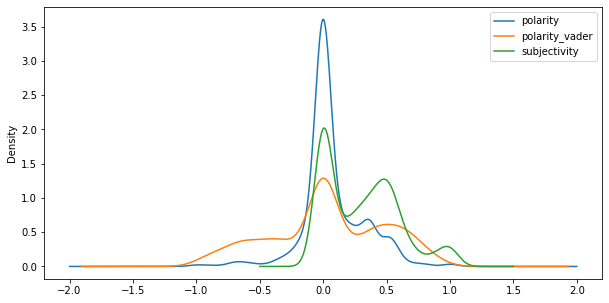

In [13]:
df.plot(figsize=(10,5), kind='density', legend=True);

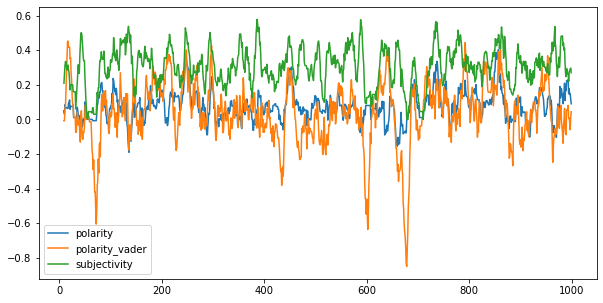

In [14]:
df.polarity.rolling(10).mean().plot(legend=True, figsize=(10,5));
df.polarity_vader.rolling(10).mean().plot(legend=True, figsize=(10,5));
df.subjectivity.rolling(10).mean().plot(legend=True, figsize=(10,5));

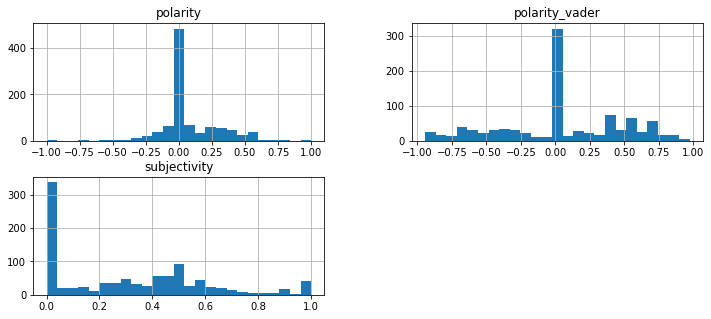

In [23]:
df.hist(bins=25, figsize=(12,5));

In [16]:
df.describe()

,polarity,polarity_vader,subjectivity
count,1000.000000,1000.000000,1000.000000
mean,0.074530,0.038492,0.303979
std,0.242084,0.447629,0.288944
min,-1.000000,-0.945100,0.000000
25%,0.000000,-0.273200,0.000000
50%,0.000000,0.000000,0.300000
75%,0.182224,0.401900,0.500000
max,1.000000,0.973000,1.000000


In [17]:
df[df.polarity==0].count()

Tweets             438
Timestamp          438
Processed_Tweet    438
polarity           438
polarity_vader     438
subjectivity       438
dtype: int64

In [18]:
df[df.polarity_vader==0].count()

Tweets             315
Timestamp          315
Processed_Tweet    315
polarity           315
polarity_vader     315
subjectivity       315
dtype: int64

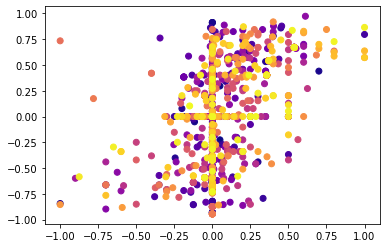

In [19]:
colors = np.array(np.arange(0, 1000))
plt.scatter(x=df.polarity, y=df.polarity_vader, c=colors, cmap='plasma');